# Neutrophil Temporal Dynamics Analysis

## Overview
This notebook performs deep temporal analysis of neutrophil transcriptional dynamics over a time course. Starting from the multi-cell-type atlas, we focus specifically on neutrophils (cluster 2) and use DRVI with higher resolution (48 latent dimensions) to capture fine-grained temporal variation.

**Key Steps:**
1. Load the processed blood cell atlas and extract neutrophils
2. Re-train DRVI with 48 latent dimensions for higher resolution
3. Identify latent dimensions that significantly change over time using OLS regression
4. Associate genes with time-varying latent dimensions
5. Perform pathway enrichment to interpret biological processes changing over time
6. Analyze stress response signatures (MP5 genes)

**Goal:** Understand which biological pathways are activated or suppressed in neutrophils across the time course (0h, 2h, 4h, 6h, 8h, 24h)


## 🔧 Setup & Environment

Mount Google Drive and install required packages including `decoupler` for pseudobulk analysis and `gseapy` for pathway enrichment.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install decoupler gseapy scikit-misc drvi-py 'scanpy[leiden]'

In [ ]:
!pip uninstall torchvision

In [ ]:
!pip install --upgrade scanpy

In [ ]:
import re
import drvi
import scvi
import numpy
import torch
import gseapy
import scanpy
import pandas
import warnings
import decoupler
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from statsmodels.formula.api import mixedlm, ols
from statsmodels.stats.multitest import multipletests


In [ ]:
scvi.settings.seed = 0
warnings.filterwarnings('ignore')
torch.set_float32_matmul_precision('high')

INFO: Global seed set to 0
INFO:lightning.fabric.utilities.seed:Global seed set to 0


## 📂 Data Loading

Load the processed blood cell atlas from the previous notebook (`BloodCellAtlas.ipynb`).


In [ ]:
dataset = '/content/drive/My Drive/neutrophills_singlecell/all_celltypes.h5ad'

In [ ]:
adata = scanpy.read_h5ad(dataset).raw.to_adata()

## 🎯 Neutrophil Selection

Extract only neutrophils (Leiden cluster 2) from the multi-cell-type atlas for focused temporal analysis.


In [ ]:
adata = adata[adata.obs['leiden'] == '2', :].copy() # type: ignore

## 🧬 Feature Selection

Select 3000 highly variable genes within neutrophils, accounting for donor effects. This higher number allows us to capture more subtle temporal variation.


In [ ]:
batch = 'donor'

adata.raw = adata.copy() # type: ignore
adata.layers['counts'] = adata.X.copy() # type: ignore

scanpy.pp.highly_variable_genes(
    adata, flavor='seurat_v3', span=1, subset=False,
    batch_key=batch, layer='counts', n_top_genes=3000
)

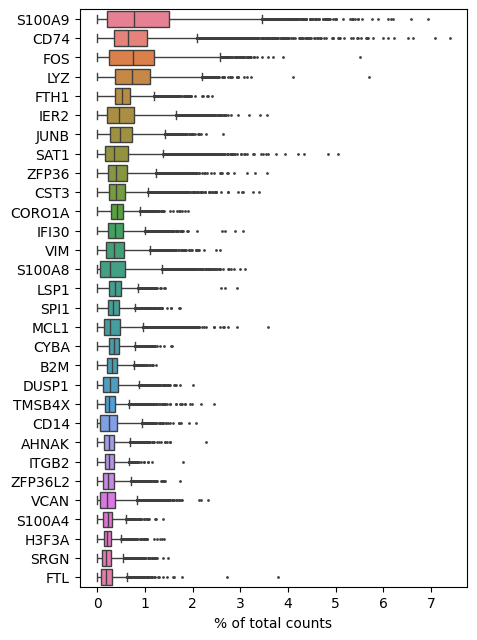

In [ ]:
scanpy.pl.highest_expr_genes(adata, layer='counts')

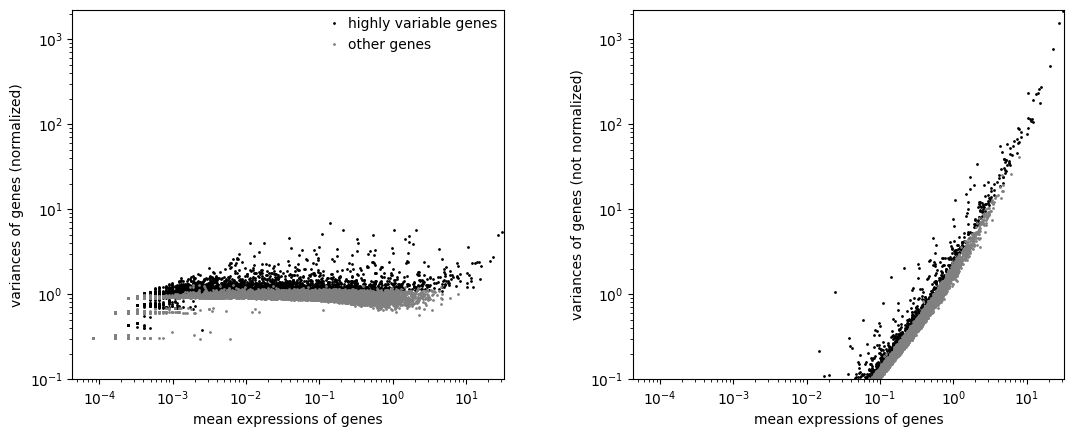

In [ ]:
scanpy.pl.highly_variable_genes(adata, log=True)

In [ ]:
adata = adata[:, adata.var['highly_variable']].copy() # type: ignore

## 🧠 DRVI Model Training (High Resolution)

Train DRVI with **48 latent dimensions** to capture fine-grained temporal variation within neutrophils. We regress out donor effects but keep time effects to study temporal dynamics.

- **Latent dimensions:** 48 (higher than cell type discovery for detailed temporal analysis)
- **Covariates:** donor only (time is the biological signal we want to study)
- **Training:** 50 epochs with early stopping


In [ ]:
batch_key = ['donor']

drvi.model.DRVI.setup_anndata(adata, layer='counts', categorical_covariate_keys=batch_key, is_count_data=True)

model = drvi.model.DRVI(adata, n_latent=48, categorical_covariates=batch_key)

In [ ]:
n_epochs = 50

plan = {'n_epochs_kl_warmup': n_epochs}

model.train(max_epochs=n_epochs, early_stopping=True, early_stopping_patience=10)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 50/50: 100%|██████████| 50/50 [01:36<00:00,  1.90s/it, v_num=1, train_loss_step=746, train_loss_epoch=716]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [01:36<00:00,  1.92s/it, v_num=1, train_loss_step=746, train_loss_epoch=716]


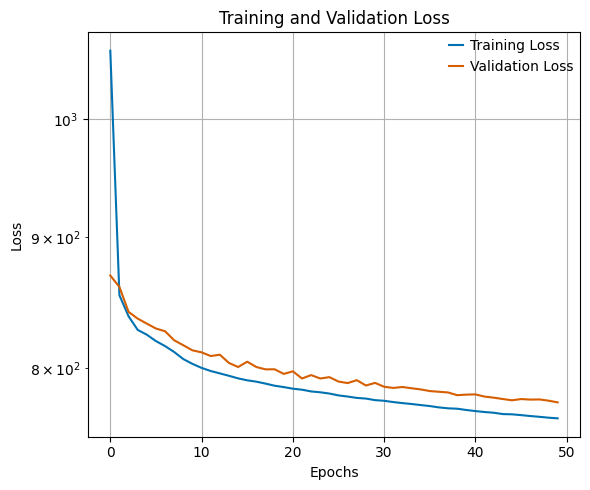

In [ ]:
elbo = model.history['elbo_train'] # type: ignore
elbo['elbo_validation'] = model.history['elbo_validation'] # type:ignore

val_color = '#D55E00'  # Orange
train_color = '#0072B2'  # Blue

# Plotting
plt.figure(figsize=(6, 5))

# Plot Loss
plt.plot(elbo.index,  elbo['elbo_train'], color=train_color, linestyle='-', label='Training Loss')
plt.plot(elbo.index, elbo['elbo_validation'], color=val_color, linestyle='-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()

In [ ]:
model.save('/content/drive/My Drive/neutrophills_singlecell/model.pt', overwrite=True)

adata.obsm['X_drvi'] = model.get_latent_representation() # type: ignore

## 📊 Dimensionality Reduction & Visualization

Compute UMAP embedding from the DRVI latent space for visualization of temporal patterns.


In [ ]:
scanpy.pp.neighbors(adata, use_rep='X_drvi', metric='correlation')
scanpy.tl.umap(adata, min_dist=0.3)

In [ ]:
scanpy.pp.subsample(adata, fraction=1.0)

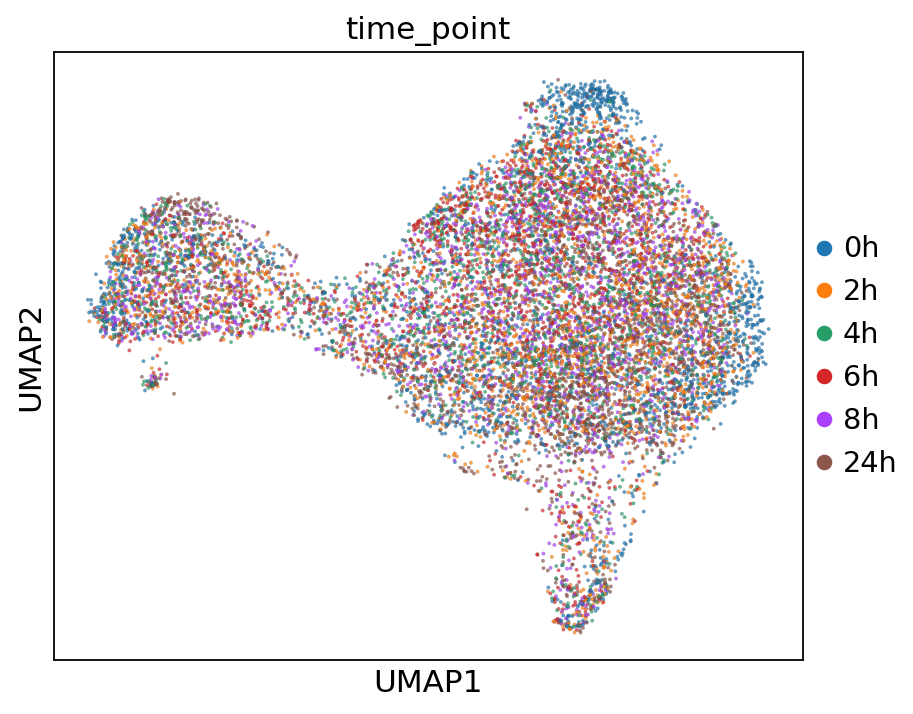

In [ ]:
scanpy.settings.set_figure_params(figsize=(6, 5)) # type: ignore
scanpy.pl.umap(adata, color='time_point', size=10, alpha=0.7, edgecolor='black', linewidth=0.05)

In [ ]:
scanpy.tl.leiden(adata, resolution=0.3)

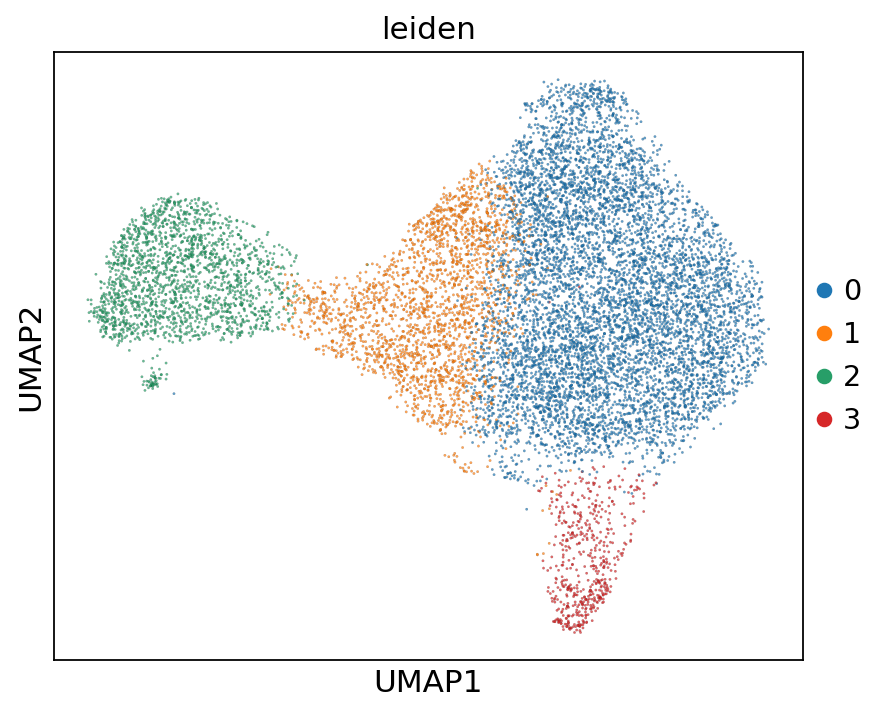

In [ ]:
scanpy.settings.set_figure_params(figsize=(6, 5)) # type: ignore
scanpy.pl.umap(adata, color='leiden', size=5, alpha=0.7, edgecolor='black', linewidth=0.05)

## 🔬 Latent Space Analysis

Create an AnnData object from the latent space for interpretability analysis and visualization of latent dimensions.


In [ ]:
Z = adata.obsm['X_drvi']

n_latent = Z.shape[1]


embed = scanpy.AnnData(
    X=Z,
    obs=adata.obs.copy(),
    var=pandas.DataFrame(index=[f"z{j}" for j in range(n_latent)]),
)

embed.var['original_dim_id'] = numpy.arange(n_latent)

drvi.utils.tl.set_latent_dimension_stats(model, embed)

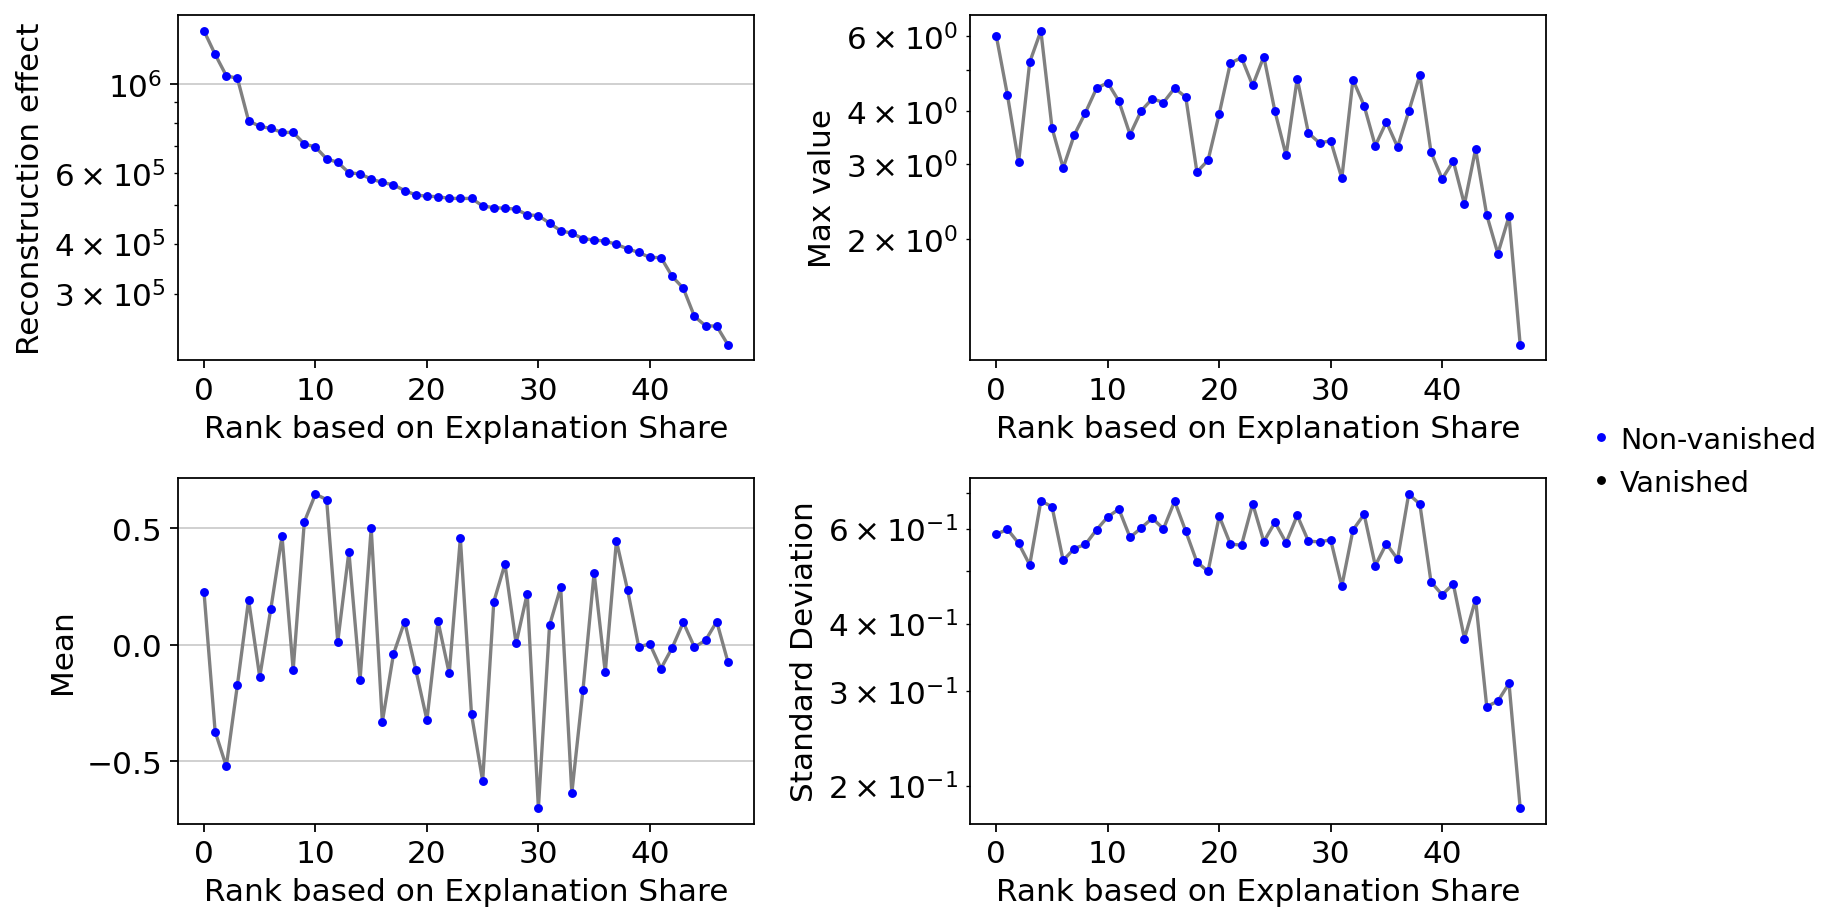

In [ ]:
drvi.utils.pl.plot_latent_dimension_stats(embed, ncols=2)

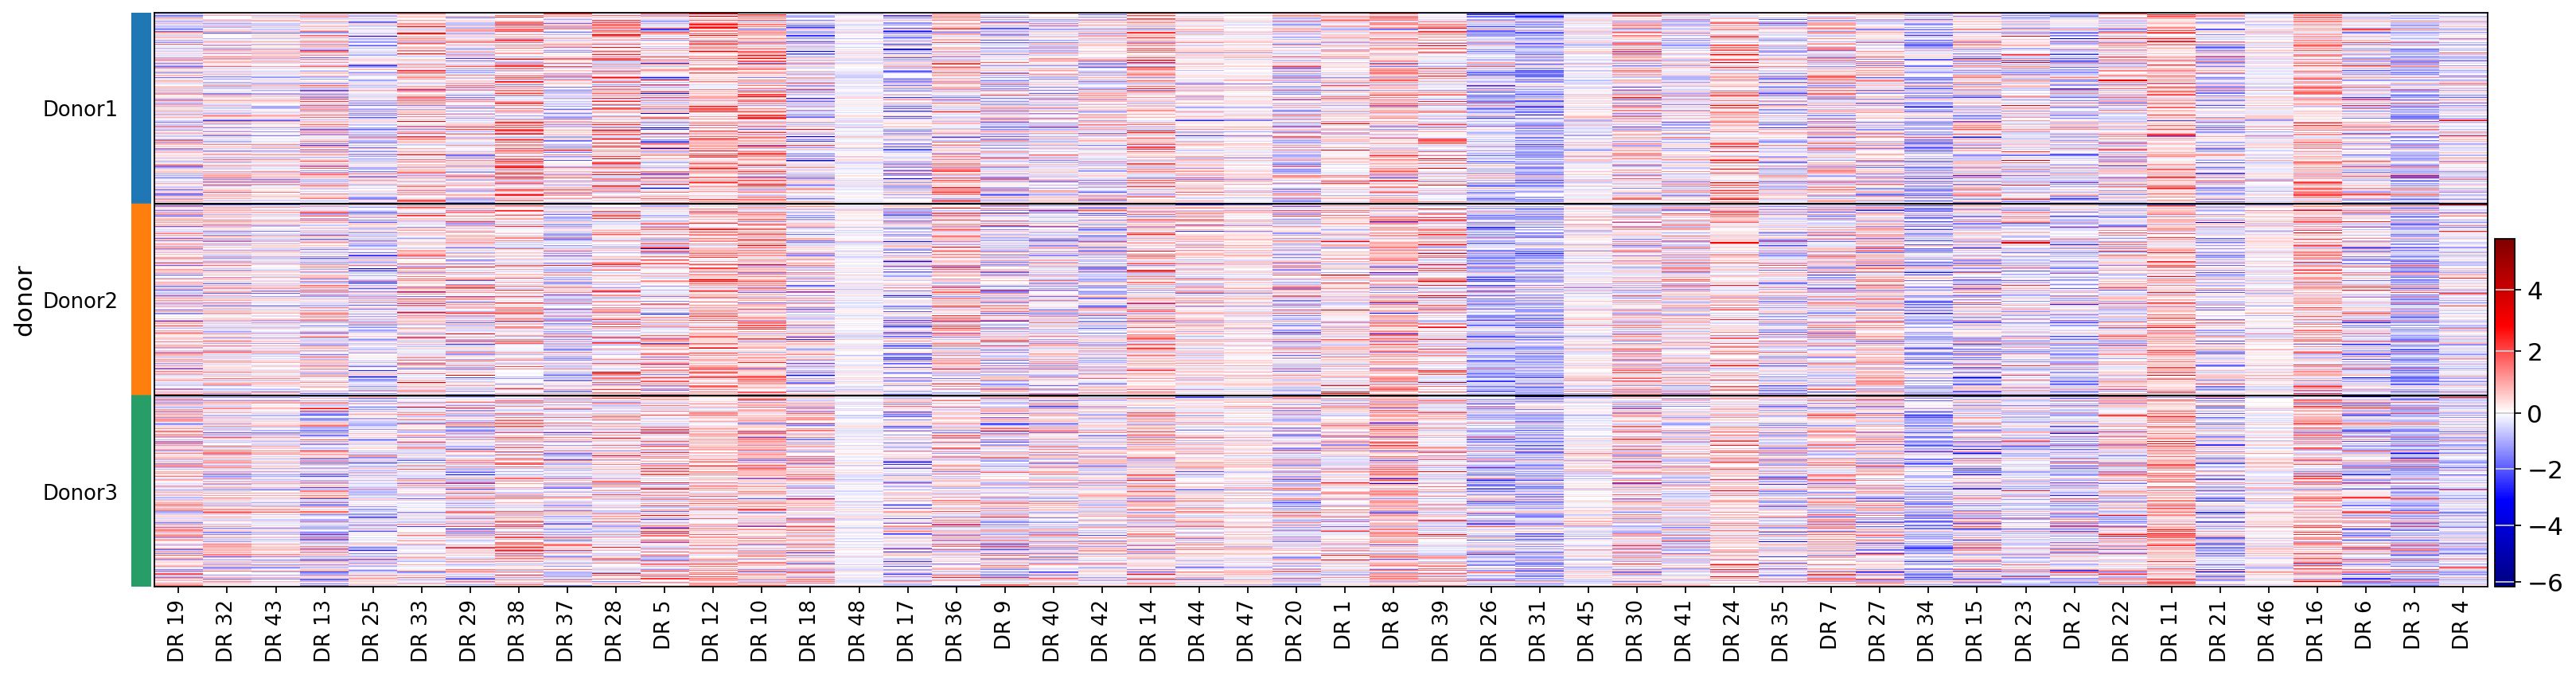

In [ ]:
drvi.utils.pl.plot_latent_dims_in_heatmap(embed, 'donor', title_col='title', sort_by_categorical=True, figsize=(24, 6))

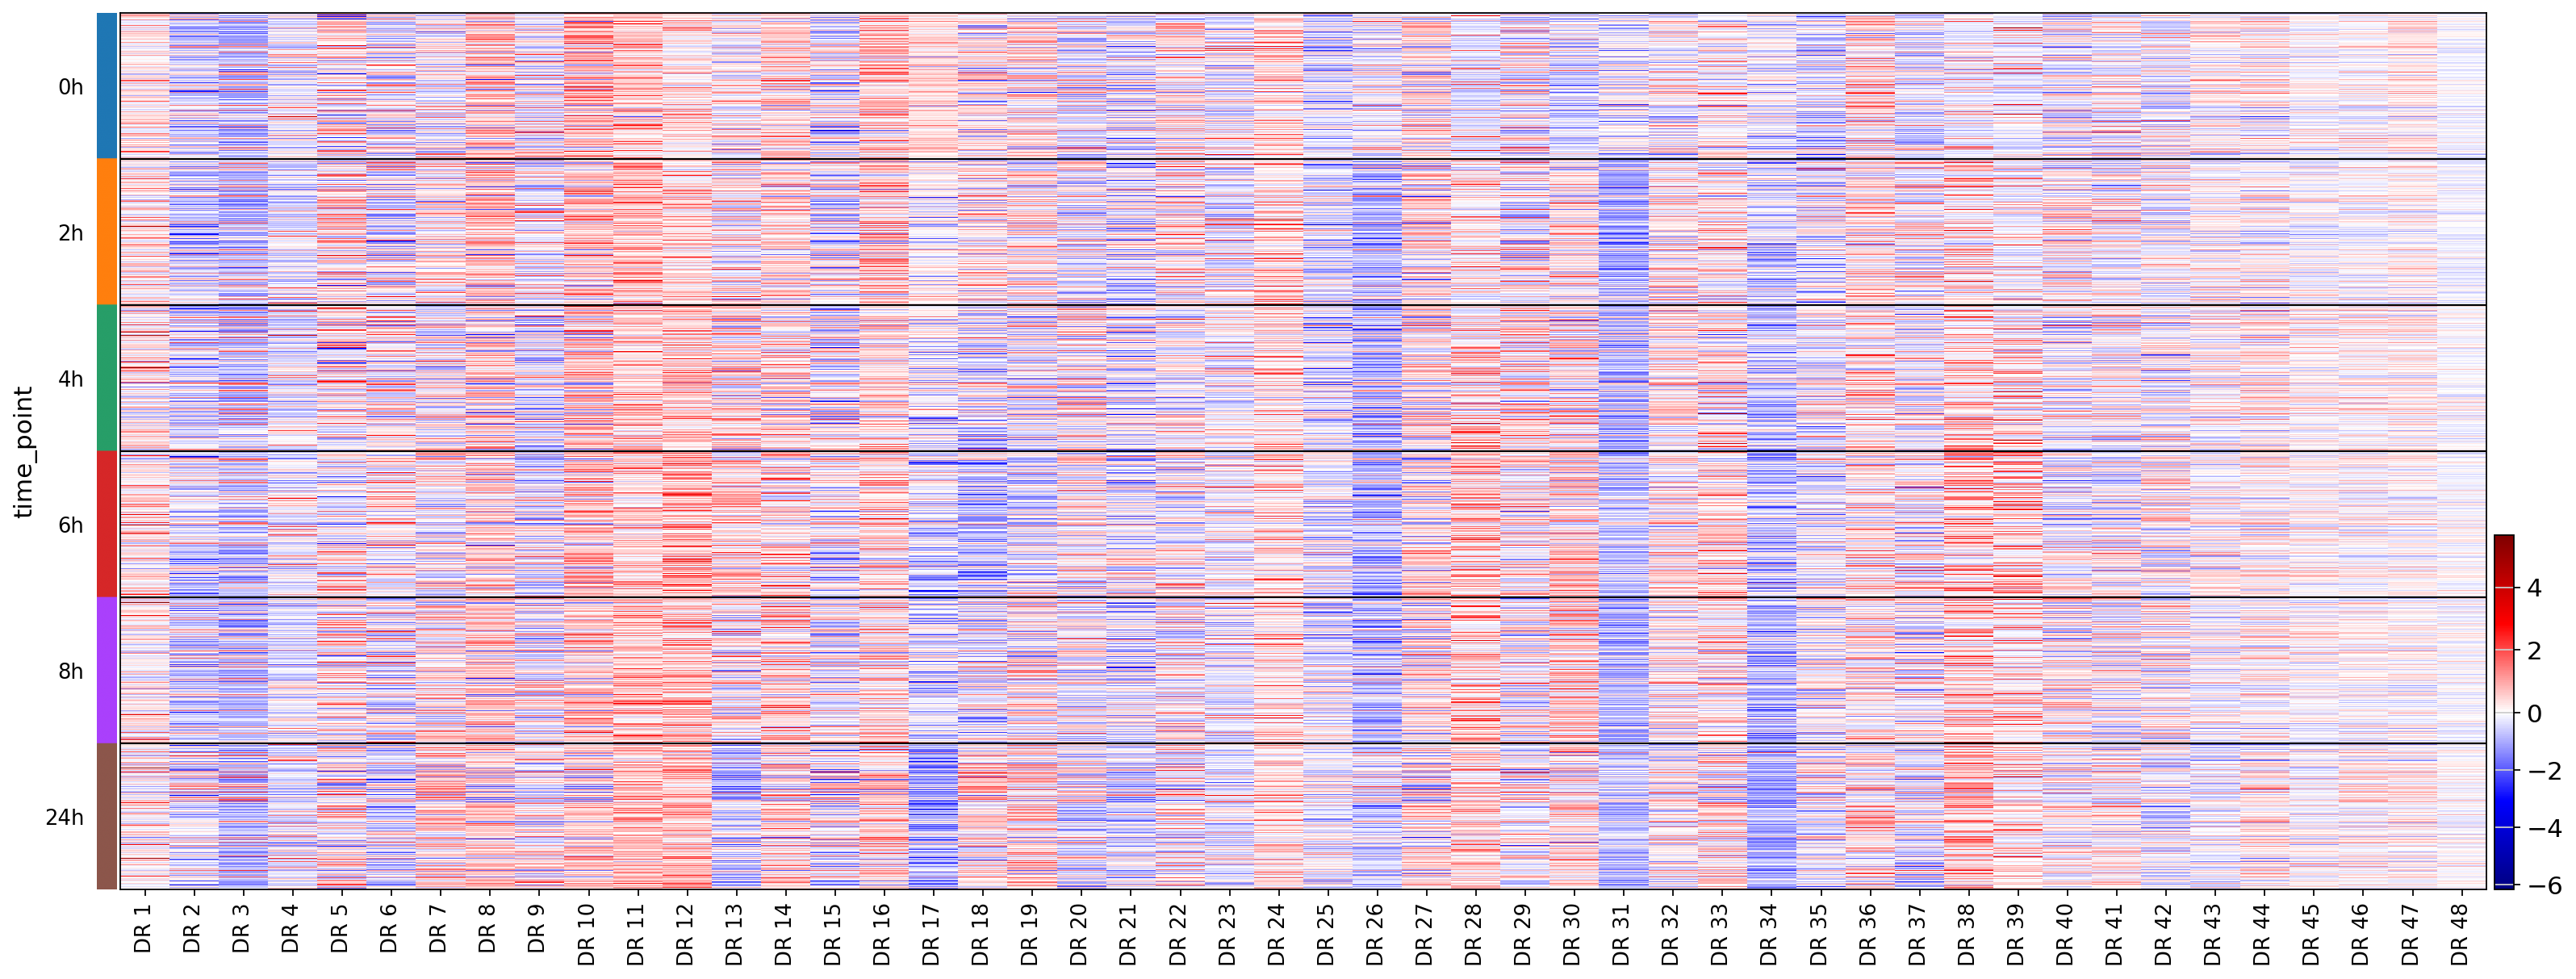

In [ ]:
drvi.utils.pl.plot_latent_dims_in_heatmap(embed, 'time_point', title_col='title', sort_by_categorical=False, figsize=(24, 9))

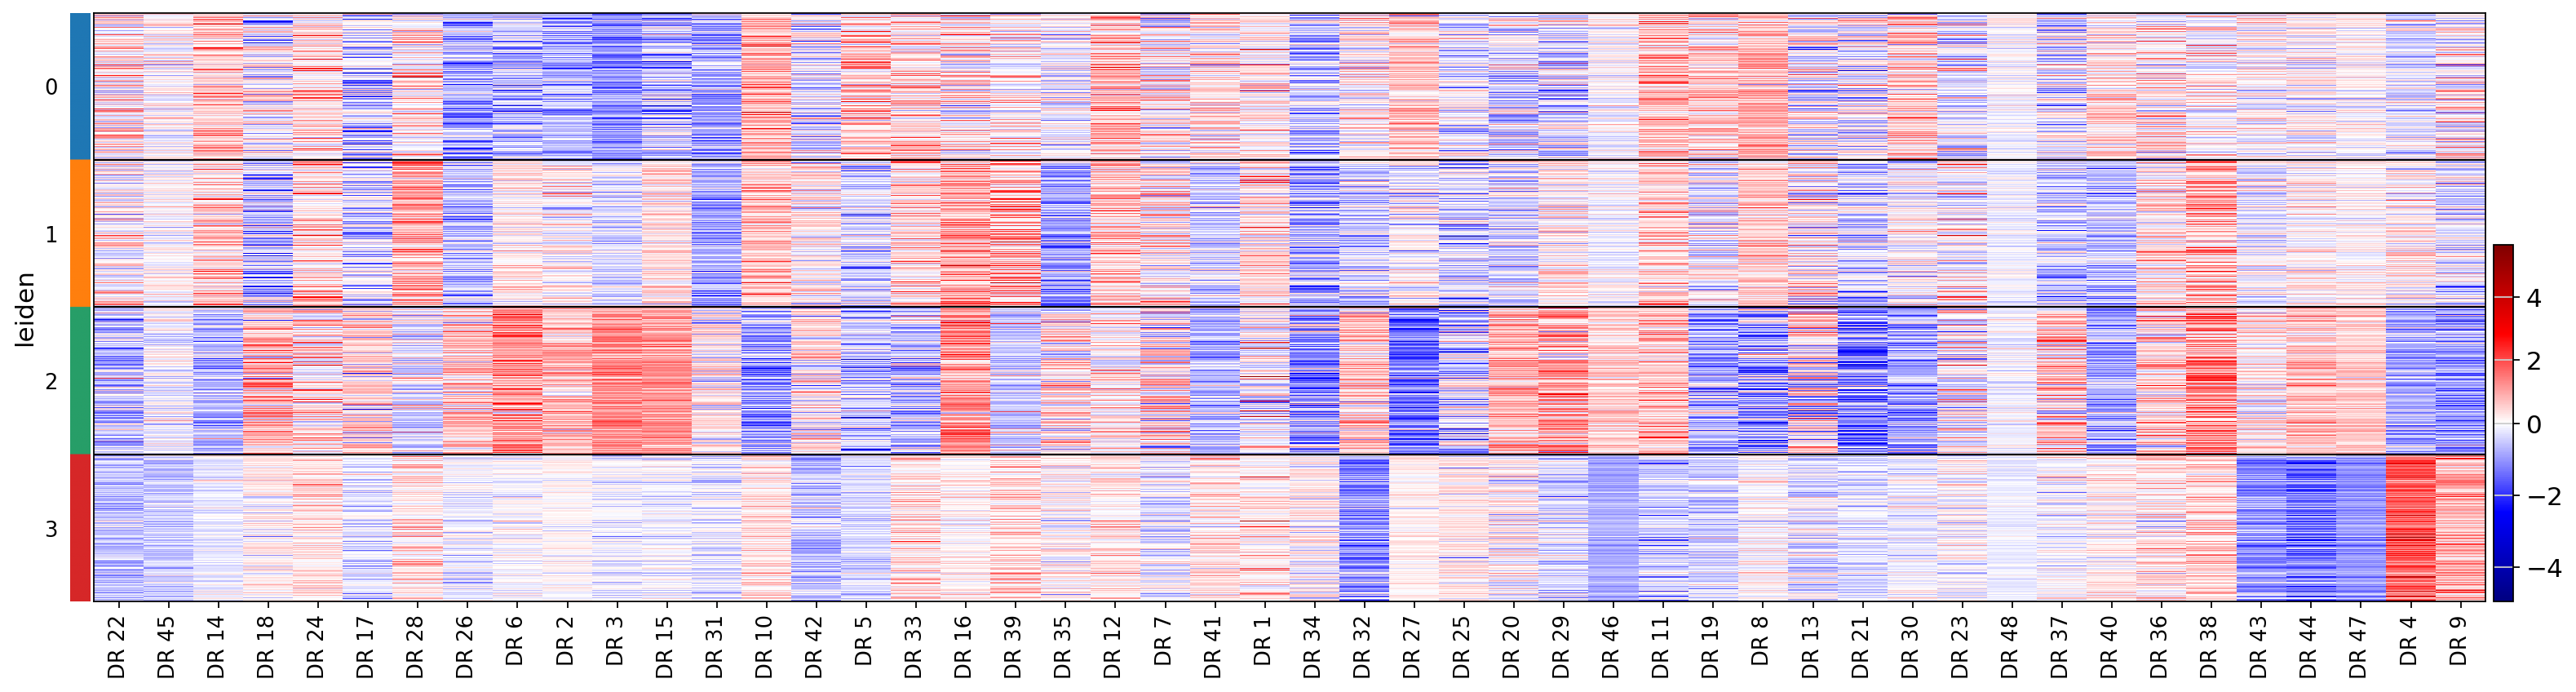

In [ ]:
drvi.utils.pl.plot_latent_dims_in_heatmap(embed, 'leiden', title_col='title', sort_by_categorical=True, figsize=(24, 6))

## 🔥 MP5 Stress Response Score

Calculate a stress response score based on immediate-early genes (FOS, JUN, EGR1, ATF3, etc.) - markers of cellular stress and activation. These genes are often induced rapidly in response to stimuli.


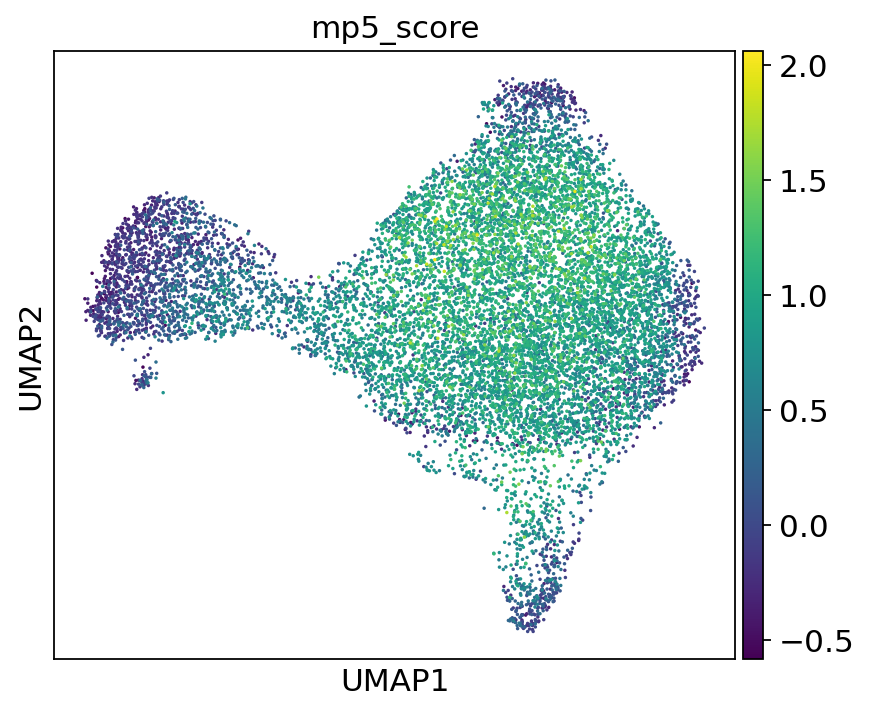

In [ ]:
adata.layers['logcounts'] = adata.X.copy() # type: ignore

scanpy.pp.normalize_total(adata, layer='logcounts')
scanpy.pp.log1p(adata, layer='logcounts')


mp5 = ['FOS','FOSB','JUN','JUNB','IER2','IER3','EGR1','ATF3','HSPA1A','HSPA1B','DNAJB1']

genes = [g for g in mp5 if g in adata.var_names]

scanpy.tl.score_genes(adata, gene_list=genes, score_name='mp5_score', layer='logcounts')

scanpy.pl.umap(adata, color='mp5_score')

## 🧬 Gene-Latent Association

Identify top genes associated with each latent dimension through latent traversal. This reveals which genes are most responsive to changes in each latent dimension.


In [ ]:
traverse_adata = drvi.utils.tl.traverse_latent(model, embed, n_samples=20, max_noise_std=0.0)
drvi.utils.tl.calculate_differential_vars(traverse_adata)

degs = drvi.utils.tools.iterate_on_top_differential_vars(traverse_adata, 'combined_score') # type: ignore

def drvi_top_table(deg_tuples, top_n=5):
    rows = []
    for label, series in deg_tuples:
        # label looks like 'DR 1-' or 'DR 1+'
        m = re.match(r'^(.*?)([+-])$', str(label).strip())
        if m:
            latent, direction = m.group(1).strip(), m.group(2)
        else:
            latent, direction = str(label).strip(), ''

        # ensure Series and sort descending
        s = pandas.Series(series).sort_values(ascending=False).head(top_n)

        for gene, score in s.items():
            rows.append({
                'gene': str(gene),
                'latent': latent,       # e.g., 'DR 1'
                'direction': direction, # '+' or '-'
                'score': float(score)
            })

    return pandas.DataFrame(rows, columns=['gene', 'latent', 'direction', 'score'])


top_genes = drvi_top_table(degs)

traversing latent ...
Input latent shape: control: (19200, 48), effect: (19200, 48)
Output mean param shape: control: (19200, 3000), effect: (19200, 3000)
Finding differential variables per latent dimension ...


## ⏱️ Temporal Analysis (OLS Regression)

**Key Analysis:** Perform pseudobulk aggregation by donor and time point, then use **OLS regression** to identify which latent dimensions significantly change over time.

For each latent dimension:
- Z-score normalize across samples
- Fit: `latent ~ time + donor`
- Test significance of time coefficient
- Correct for multiple testing (FDR)

This identifies latent dimensions capturing temporal dynamics while controlling for donor effects.


In [ ]:
pdata = decoupler.pp.pseudobulk(adata=embed, sample_col='donor', groups_col='time_point', mode='mean', skip_checks=True)

In [ ]:
pdata

AnnData object with n_obs × n_vars = 18 × 48
    obs: 'donor', 'time_point', 'tissue', 'capture_batch', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'predicted_doublet', '_scvi_labels', 'psbulk_cells', 'psbulk_counts'
    var: 'original_dim_id', 'reconstruction_effect', 'order', 'max_value', 'mean', 'min', 'max', 'std', 'title', 'vanished'
    layers: 'psbulk_props'

In [ ]:
# 0) Tidy dataframe
df = pdata.to_df().join(pdata.obs.copy())


# 1) Ensure numeric time
if 'time_point_int' not in df.columns:
    df['time_point_int'] = (
        df['time_point'].astype(str).str.strip().str.replace('h', '', regex=False).astype(int)
    )


# 2) Choose latents
latents = list(pdata.var_names)
if 'vanished' in pdata.var.columns:
    latents = [lv for lv in latents if not bool(pdata.var.loc[lv, 'vanished'])]


# 2a) Z-score each latent (store as new columns with '_z')
Z = df[latents].astype(float)
mean = Z.mean(0)
std = Z.std(0, ddof=0).replace(0.0, 1.0)
Zz = (Z - mean) / std

for c in latents:
    df[c + '_z'] = Zz[c]

results = []


# 3) OLS per latent (use z-scored values): latent_z ~ time_point_int + C(donor)
for latent in latents:
    dsub = df[['time_point_int', 'donor', latent + '_z']].dropna()
    if dsub.empty:
        continue
    fit = ols(f'{latent}_z ~ time_point_int + C(donor)', data=dsub).fit()

    slope = fit.params.get('time_point_int', numpy.nan)
    pval = fit.pvalues.get('time_point_int', numpy.nan)
    stderr = fit.bse.get('time_point_int', numpy.nan)
    intercept = fit.params.get('Intercept', numpy.nan)

    results.append({
        'latent': latent,  # report original name
        'slope_time': slope,
        'pval_time': pval,
        'se_time': stderr,
        'intercept': intercept
    })


# 4) Multiple testing correction
res_df = pandas.DataFrame(results).sort_values('pval_time').reset_index(drop=True)

if not res_df.empty:
    res_df['fdr_bh'] = multipletests(res_df['pval_time'].values, method='fdr_bh')[1]
    res_df['neglog10_p'] = -numpy.log10(res_df['pval_time'].clip(lower=1e-300))
    res_df['direction'] = numpy.where(res_df['slope_time'] > 0, 'up_with_time', 'down_with_time')


# 5) Optional: join latent metadata
meta_cols = [c for c in ['title', 'original_dim_id', 'reconstruction_effect'] if c in pdata.var.columns]

if meta_cols and not res_df.empty:
    meta_df = pdata.var[meta_cols].copy()
    meta_df['latent'] = meta_df.index
    res_df = res_df.merge(meta_df, on='latent', how='left')


In [ ]:
res_df[res_df['fdr_bh'] < 0.01]

,latent,slope_time,pval_time,se_time,intercept,fdr_bh,neglog10_p,direction,title,original_dim_id,reconstruction_effect
0,z9,-0.113357,0.000002,0.014337,0.679079,0.000075,5.804093,down_with_time,DR 17,9,5.683769e+05
1,z21,-0.086530,0.000008,0.012581,1.482823,0.000182,5.120040,down_with_time,DR 10,21,7.091888e+05
2,z37,0.091545,0.000072,0.016507,-0.815803,0.001154,4.142100,up_with_time,DR 2,37,1.185782e+06
3,z45,-0.086346,0.000207,0.017385,1.151154,0.002483,3.684205,down_with_time,DR 43,45,3.313104e+05
4,z7,-0.095204,0.000645,0.021803,0.554594,0.006193,3.190404,down_with_time,DR 34,7,4.245292e+05


In [ ]:
top_genes[top_genes['latent'] == 'DR 34']

,gene,latent,direction,score
316,RHOB,DR 34,-,3.924892
317,DUSP1,DR 34,-,0.158412
318,KLF2,DR 34,-,0.135567
319,C5AR1,DR 34,-,0.088997
320,MAFB,DR 34,-,0.077253
321,SULT1B1,DR 34,+,0.026309


## 📈 Visualization of Time-Varying Genes

Visualize genes associated with significantly time-varying latent dimensions using a matrix plot grouped by latent dimension and direction.


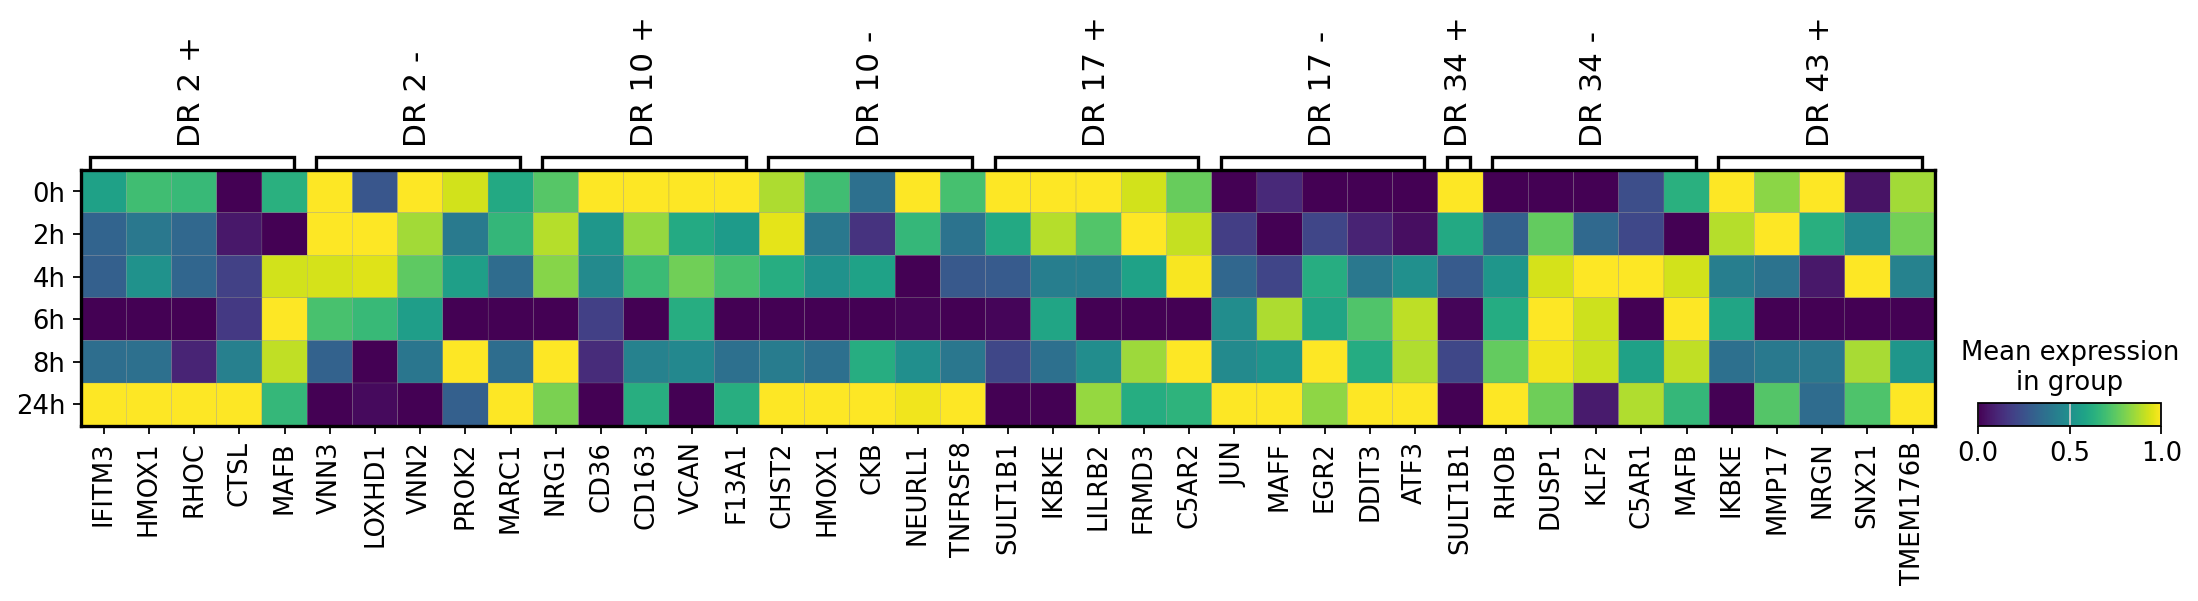

In [ ]:
def build_blocks(top_genes, adata, significant_latents=None, n_top=8):
    # default: every latent present in top_genes
    if significant_latents is None:
        significant_latents = list(top_genes['latent'].unique())

    def genes_for(latent, direction, n):
        sub = (top_genes[(top_genes['latent'] == latent) &
                         (top_genes['direction'] == direction)]
               .sort_values('score', ascending=False))
        genes = [g for g in sub['gene'].tolist() if g in adata.var_names]
        return genes[:n]

    blocks = []
    for latent in sorted(significant_latents, key=lambda x: (x.split()[0], int(x.split()[-1])) if x.split()[-1].isdigit() else x):
        for d in ['+','-']:
            g = genes_for(latent, d, n_top)
            if g:
                blocks.append((f'{latent} {d}', g))
    return blocks

def flatten_blocks(blocks):
    var_names, var_group_positions, labels = [], [], []
    start = 0
    for label, genes in blocks:
        var_names.extend(genes)
        end = start + len(genes) - 1
        var_group_positions.append((start, end))
        labels.append(label)
        start = end + 1
    return var_names, var_group_positions, labels

# === usage ===
sig_latents = res_df[res_df['fdr_bh'] < 0.01]['title'].tolist()
blocks = build_blocks(top_genes, adata, significant_latents=sig_latents, n_top=5)  # or pass your DR list
var_names, var_group_positions, var_group_labels = flatten_blocks(blocks)

scanpy.pl.matrixplot(
    adata,
    var_names=var_names,
    groupby='time_point',
    use_raw=False,
    standard_scale='var',
    layer='logcounts',
    var_group_positions=var_group_positions,
    var_group_labels=var_group_labels,
    dendrogram=False,
    swap_axes=False
)

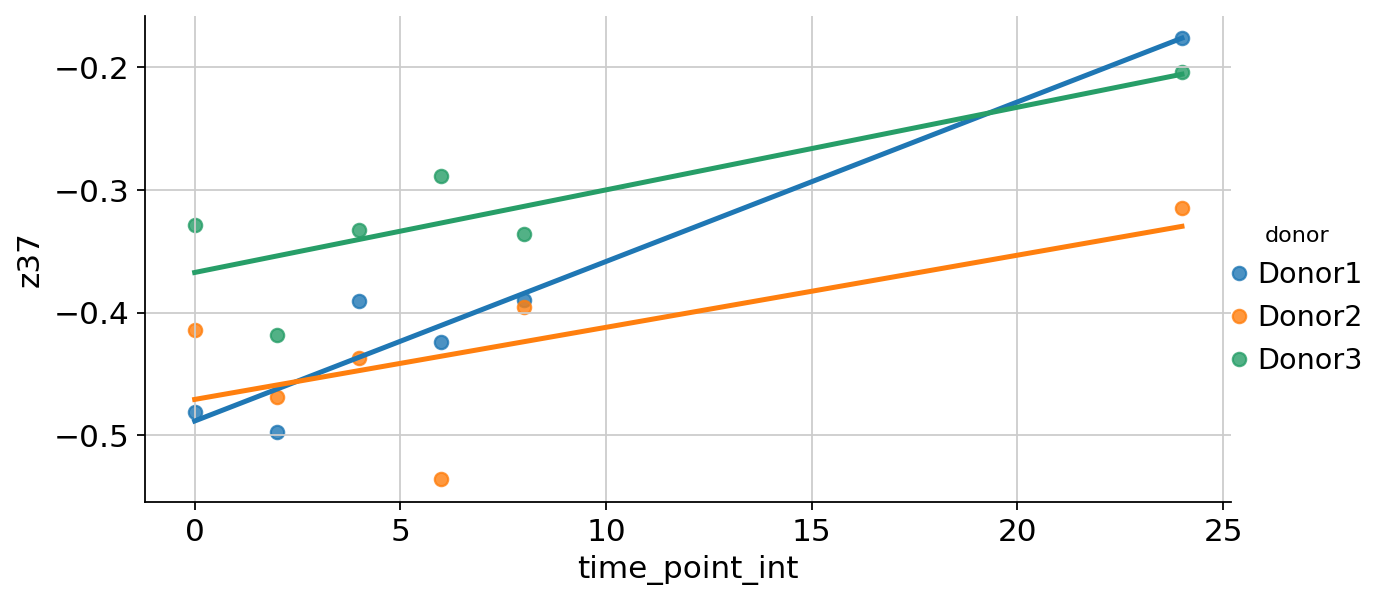

In [ ]:
sns.lmplot(
    data=df, x='time_point_int', y='z37',
    hue='donor', markers='o', ci=0, height=4, aspect=2
)

In [ ]:
top_genes.to_csv('/content/drive/My Drive/neutrophills_singlecell/top_genes_neutraphils.tsv', sep='\t')

In [ ]:
top_latents = res_df[res_df['fdr_bh'] < 0.01]

In [ ]:
latent_list = top_latents['title'].tolist()

## 🧩 Gene Set Preparation for Enrichment

Identify genes that increase or decrease with time by mapping latent dimension trends to gene associations. This creates two gene sets:
- **Time+ genes:** Genes increasing over time
- **Time- genes:** Genes decreasing over time


In [ ]:
k = 5

# latents to use
latent_list = top_latents['title'].tolist()

# map latent → trend sign based on 'direction' column
trend_sign = (
    top_latents
    .assign(_sign=top_latents['direction'].map({'up_with_time': '+', 'down_with_time': '-'}))
    .set_index('title')['_sign']
    .to_dict()
)

# take top-k per latent × (DR ±)
tg = (top_genes[top_genes['latent'].isin(latent_list)]
        .sort_values('score', ascending=False)
        .groupby(['latent','direction'], group_keys=False)
        .head(k))

# map latent± → time±
def to_time_dir(row):
    s = trend_sign.get(row['latent'])
    if s == '+':   # latent goes up with time
        return '+' if row['direction'] == '+' else '-'
    if s == '-':   # latent goes down with time
        return '-' if row['direction'] == '+' else '+'
    return None

tg['time_dir'] = tg.apply(to_time_dir, axis=1) # type: ignore
tg = tg.dropna(subset=['time_dir'])

# unions
pos_with_time = sorted(set(tg.loc[tg['time_dir'] == '+', 'gene']))
neg_with_time = sorted(set(tg.loc[tg['time_dir'] == '-', 'gene']))

# optional quick checks
print('time+ genes:', len(pos_with_time))
print('time- genes:', len(neg_with_time))


time+ genes: 18
time- genes: 19


In [ ]:
gseapy.get_library_name()

In [ ]:
genesets = [
    'MSigDB_Hallmark_2020',
    'Reactome_Pathways_2024',
    'GO_Biological_Process_2025',
    'KEGG_2021_Human'
]

## 🎯 Pathway Enrichment Analysis

Perform pathway enrichment using **MSigDB Hallmark gene sets** to identify biological processes enriched in genes that increase or decrease over time.

This reveals the functional consequences of temporal changes in neutrophils.


In [ ]:
msig = gseapy.Msigdb()
gmt = msig.get_gmt(category='h.all', dbver='2025.1.Hs')

In [ ]:
enr = gseapy.enrichr(gene_list=pos_with_time, gene_sets=gmt, organism='human', outdir=None, background=adata.raw.var_names) # type: ignore
enr.results[enr.results['Adjusted P-value'] < 0.05].sort_values('Adjusted P-value').head(10) # type: ignore

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
7,gs_ind_0,HALLMARK_HYPOXIA,7/200,3.654302e-12,4.567877e-11,124.079879,3267.658007,CHST2;ATF3;DUSP1;DDIT3;HMOX1;MAFF;JUN
20,gs_ind_0,HALLMARK_TNFA_SIGNALING_VIA_NFKB,7/199,3.527322e-12,4.567877e-11,124.727837,3289.133217,KLF2;RHOB;JUN;ATF3;DUSP1;MAFF;EGR2
0,gs_ind_0,HALLMARK_APOPTOSIS,6/159,1.014654e-10,8.455452e-10,124.849121,2872.940942,RHOB;IFITM3;ATF3;DDIT3;HMOX1;JUN
17,gs_ind_0,HALLMARK_P53_PATHWAY,4/192,2.025976e-06,1.144686e-05,60.619318,794.686465,ATF3;HMOX1;JUN;DDIT3
8,gs_ind_0,HALLMARK_IL2_STAT5_SIGNALING,4/198,2.289372e-06,1.144686e-05,58.739739,762.866673,RHOB;TNFRSF8;IFITM3;MAFF
23,gs_ind_0,HALLMARK_UV_RESPONSE_UP,3/156,5.715059e-05,2.381275e-04,54.214879,529.669648,ATF3;HMOX1;RHOB
9,gs_ind_0,HALLMARK_IL6_JAK_STAT3_SIGNALING,2/87,8.148933e-04,2.910333e-03,65.430622,465.372249,HMOX1;JUN
3,gs_ind_0,HALLMARK_COMPLEMENT,2/200,4.196210e-03,1.049052e-02,28.096710,153.789412,CTSL;MAFF
10,gs_ind_0,HALLMARK_INFLAMMATORY_RESPONSE,2/200,4.196210e-03,1.049052e-02,28.096710,153.789412,CHST2;C5AR1
4,gs_ind_0,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,2/200,4.196210e-03,1.049052e-02,28.096710,153.789412,RHOB;JUN


In [ ]:
enr = gseapy.enrichr(gene_list=neg_with_time, gene_sets=gmt, organism='human', outdir=None, background=adata.raw.var_names) # type: ignore
enr.results[enr.results['Adjusted P-value'] < 0.05].sort_values('Adjusted P-value').head(10) # type: ignore

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
10,gs_ind_0,HALLMARK_KRAS_SIGNALING_UP,2/199,0.004628,0.030082,26.625316,143.128127,F13A1;TMEM176B
12,gs_ind_0,HALLMARK_XENOBIOTIC_METABOLISM,2/196,0.004493,0.030082,27.038193,146.146379,CD36;TMEM176B
